In [6]:
%load_ext autoreload
%autoreload 2
     
import torch
import os
from matplotlib import pyplot as plt
from csng.brainreader_mouse.data import get_brainreader_mouse_dataloaders
from math import prod
from torchvision import transforms

import os
from os.path import join
import torch
from torchvision.datasets import ImageNet
from torchvision import transforms
from torchvision.transforms import functional as F
import torch.nn.functional as batch
import torchvision
import torch.nn as nn

from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
from random import random
import torch.multiprocessing as mp
from torch.utils.data import random_split, DataLoader, Subset
from csng.imagenet.models import ReadIn, ResnetExtractor, UpsampleModel

assert torch.cuda.is_available()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Using cache found in /home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [7]:

device = os.environ["DEVICE"]
DATA_PATH = os.environ['DATA_PATH']
CACHE_DIR = os.path.join(DATA_PATH, 'brainreader_cache')
DATA_PATH_BRAINREADER = os.path.join(DATA_PATH, 'brainreader')

BATCH_SIZE = 64
EPOCHS = 50
WEIGHT_DECAY=0e-4
LEARNING_RATE = .0002* BATCH_SIZE
READIN_DTYPE = torch.bfloat16
RESNET_DECODE_MODEL = '/scratch/izar/vanousek/cs-433-project/models/mlp2489100.pt'

utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils', )

Using cache found in /home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [8]:
config = {
    "device": os.environ["DEVICE"],
    "seed": 0,
    "data": {
        "mixing_strategy": "sequential", # needed only with multiple base dataloaders
        "max_training_batches": None,
    },
    "save_path": os.path.join(DATA_PATH, "models", "encoder_ball_50.pt"),
    # "load_ckpt": os.path.join(DATA_PATH, "models", "encoder_ball.pt"),
    "train": True,
}
config["data"]["brainreader_mouse"] = {
    "device": config["device"],
    "mixing_strategy": config["data"]["mixing_strategy"],
    "max_batches": None,
    "data_dir": os.path.join(DATA_PATH_BRAINREADER, "data"),
    "batch_size": BATCH_SIZE,
    # "sessions": list(range(1, 23)),
    "sessions": [1],
    "resize_stim_to": (224, 224),
    "normalize_stim": False,
    "normalize_resp": True,
    "div_resp_by_std": True,
    "clamp_neg_resp": True,
    "additional_keys": None,
    "avg_test_resp": True,
}

dl = get_brainreader_mouse_dataloaders(config=config["data"]["brainreader_mouse"])['brainreader_mouse']
print(len(dl['train']), len(dl['test']))

71 2


1
torch.Size([64, 1, 224, 224])
torch.Size([64, 9395])
1


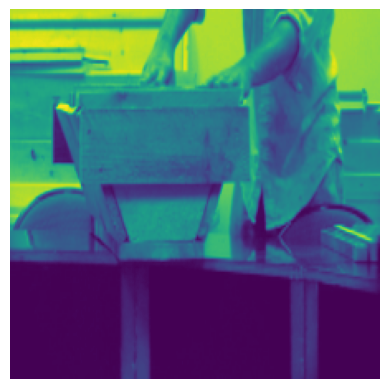

In [9]:
def show_image(img_tensor, title=''):
    img = img_tensor.cpu().numpy().transpose((1, 2, 0))  # Convert to HWC
    plt.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()

items = next(dl['train'])
print(len(items))
item = items[0]
stim = item['stim']
print(stim.shape)

resp = item['resp']
print(resp.shape)
neurons = resp.shape[1]
data_key = item['data_key']
print(data_key)
# plot the stim as grayscale image with matplotlib
show_image(stim[0]) 


In [14]:
import torch
from torch.nn import functional as F





readin = ReadIn(neurons, (1024, 14, 14))
readin.apply(initialize_weights)
readin.to(device, dtype=READIN_DTYPE)
    

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
params = count_parameters(readin)
print("Total parametrs: ", params)

NameError: name 'prod' is not defined

In [12]:

optimizer = torch.optim.Adam(readin.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
criterion = torch.nn.MSELoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(dl['train'])*EPOCHS, eta_min=LEARNING_RATE/5)

extractor = ResnetExtractor()

losses = []


for epoch in range(EPOCHS):
    dl = get_brainreader_mouse_dataloaders(config=config["data"]["brainreader_mouse"])['brainreader_mouse']
    for minibatch in tqdm(dl['train']):
        assert len(minibatch) == 1
        item = minibatch[0]
        stim = item['stim'].to(device)
        resp = item['resp'].to(device, dtype=READIN_DTYPE)

        stim_rgb = torch.cat([stim, stim, stim], dim=1)
        
        with torch.cuda.amp.autocast():
            pass
        target = extractor.get_features(stim_rgb, verbose=False).to(device, dtype=READIN_DTYPE).unsqueeze(0)
        output = readin(resp)
        loss = criterion(output, target)
        loss.backward()

        # torch.nn.utils.clip_grad_norm_(readin.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        constant_loss = criterion(torch.zeros_like(output), target).item()
        relative_loss = loss.item() / (constant_loss + 1e-6)
        losses.append(relative_loss)
        # print(f"Loss: {loss.item()} Constant loss: {constant_loss} Relative loss: {relative_loss}")

        optimizer.zero_grad()
    print(f"Epoch {epoch} finished with relative loss {np.mean(losses[-len(dl['train']):])}")



NameError: name 'readin' is not defined

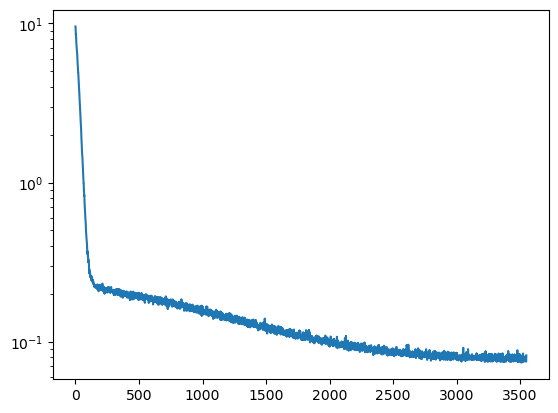

In [616]:
# Plot losses
plt.plot(losses)
plt.yscale('log')


In [617]:
# Evaluate the model
readin.eval()
test_losses = []
imgs = []
imgnet_activations_real = []
imgnet_activations_pred = []

with torch.no_grad():
    for minibatch in dl['test']:
        assert len(minibatch) == 1
        item = minibatch[0]
        stim = item['stim'].to(device)
        resp = item['resp'].to(device, dtype=READIN_DTYPE)
        stim_rgb = torch.cat([stim, stim, stim], dim=1)
        target = extractor.get_features(stim_rgb, verbose=False).to(device, dtype=READIN_DTYPE).unsqueeze(0)

        output = readin(resp)

        constant_loss = criterion(torch.zeros_like(output), target).item()
        relative_loss = loss.item() / (constant_loss + 1e-6)

        test_losses.append(relative_loss)
        imgnet_activations_real.append(target)
        imgnet_activations_pred.append(output)
        imgs.append(stim)

        print(f"Loss: {loss.item()} Constant loss: {constant_loss} Relative loss: {relative_loss}")
        print(f"Loss: {loss.item()}")
# .22
print(f"Mean loss: {np.mean(test_losses)}")
print(f"Std loss: {np.std(test_losses)}")

/home/vanousek/miniconda3/envs/csng/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 64, 1024, 14, 14])) that is different to the input size (torch.Size([64, 1024, 14, 14])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 0.0096435546875 Constant loss: 0.1162109375 Relative loss: 0.08298247920959066
Loss: 0.0096435546875
Loss: 0.0096435546875 Constant loss: 0.1181640625 Relative loss: 0.08161087959057273
Loss: 0.0096435546875
Mean loss: 0.0822966794000817
Std loss: 0.0006857998095089676


/home/vanousek/miniconda3/envs/csng/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 36, 1024, 14, 14])) that is different to the input size (torch.Size([36, 1024, 14, 14])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [ ]:

output_model = torch.load(RESNET_DECODE_MODEL)
output_model.eval()
for real, recon, pred in zip(imgs, imgnet_activations_real, imgnet_activations_pred):
    plt.figure()
    with torch.no_grad():
        real_img = output_model(real.to('cuda', dtype=torch.float32).squeeze()).squeeze()
        print(real_img.shape)
        for i in range(1, 10):
            plt.figure()
            print(real_img.shape)
            plt.imshow(real_img[i, ...].squeeze().cpu(), cmap='gray')  # Squeeze to remove extra dimension
            plt.figure()
            plt.imshow(real_img[i, ...].squeeze().cpu(), cmap='gray')  # Squeeze to remove extra dimension
            pred_img = output_model(pred.to('cuda', dtype=torch.float32)).squeeze()
            plt.figure()
            plt.imshow(pred_img[i, ...].squeeze().cpu(), cmap='gray')  # Squeeze to remove extra dimension
            plt.show()

RuntimeError: Given transposed=1, weight of size [1024, 768, 4, 4], expected input[1, 64, 224, 224] to have 1024 channels, but got 64 channels instead

<Figure size 640x480 with 0 Axes>